In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, locally_linear_embedding
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from gluonts.dataset.repository import dataset_recipes, get_dataset

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [30]:
moirai_path = os.path.join('submodules', 'uni2ts', 'src')
sys.path.append(moirai_path)
from uni2ts.eval_util.data import get_gluonts_test_dataset

# load_model
# from probts.model.forecaster.point_forecaster.patchtst import PatchTST
from probts.model.forecast_module import ProbTSForecastModule
patchtst = ProbTSForecastModule.load_from_checkpoint('exps/ckpt/etth1_96_96_PatchTST_0/last.ckpt', target_dim=7, context_length=96, prediction_length=96, freq='h', lags_list=[])

# 20240714 get patchtst embeddings

Loading Short-term Datasets: solar_nips


context_length: 96, prediction_length: 96
variate-specific normalization: True
torch.Size([1, 96, 137])
torch.Size([1, 96, 7])
torch.Size([1, 137, 16, 11])
torch.Size([1, 96, 137])
torch.Size([1, 96, 137])
torch.Size([1, 96, 137])
torch.Size([1, 96, 137])
torch.Size([1, 96, 137])


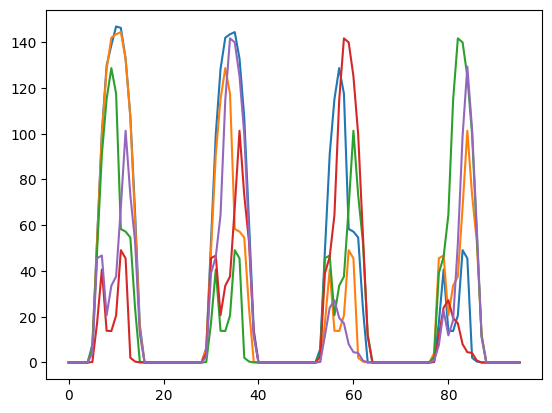

In [31]:
from probts.data.data_manager import DataManager
from torch.utils.data import DataLoader
import types

data_manager = DataManager("solar_nips", history_length=96, context_length=96, prediction_length=96, scaler='standard')
data_loader = DataLoader(data_manager.test_iter_dataset, batch_size=1)

pred, emb = patchtst.forecaster.embedding(types.SimpleNamespace(**next(iter(data_loader))))
print(pred.shape)
print(emb.shape)

loader = iter(data_loader)
for i in range(5):
    data = next(loader)
    print(data['past_target_cdf'].shape)
    # print(data['past_target_cdf'][0, -12:, 0])
    plt.plot(data['past_target_cdf'][0,:,2])

Loading Long-term Datasets: ettm1
num_test_dates:  120


/home/v-zhenwzhang/Code/ProbTS/probts/data/ltsf_datasets.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stamp['date'] = pd.to_datetime(df_stamp.date)


num_test_dates:  120
context_length: 96, prediction_length: 96
ettm1   10
Loading Long-term Datasets: etth1
num_test_dates:  30
num_test_dates:  30
context_length: 96, prediction_length: 96


/home/v-zhenwzhang/Code/ProbTS/probts/data/ltsf_datasets.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stamp['date'] = pd.to_datetime(df_stamp.date)


etth1   10
Loading Short-term Datasets: exchange_rate_nips
context_length: 96, prediction_length: 96
exchange_rate_nips   5
Loading Long-term Datasets: weather_ltsf


/home/v-zhenwzhang/Code/ProbTS/probts/data/ltsf_datasets.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stamp['date'] = pd.to_datetime(df_stamp.date)


num_test_dates:  54
num_test_dates:  109
context_length: 96, prediction_length: 96
weather_ltsf   10
Loading Long-term Datasets: exchange_ltsf
num_test_dates:  7
num_test_dates:  15
context_length: 96, prediction_length: 96


/home/v-zhenwzhang/Code/ProbTS/probts/data/ltsf_datasets.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stamp['date'] = pd.to_datetime(df_stamp.date)


exchange_ltsf   10
(470, 176)


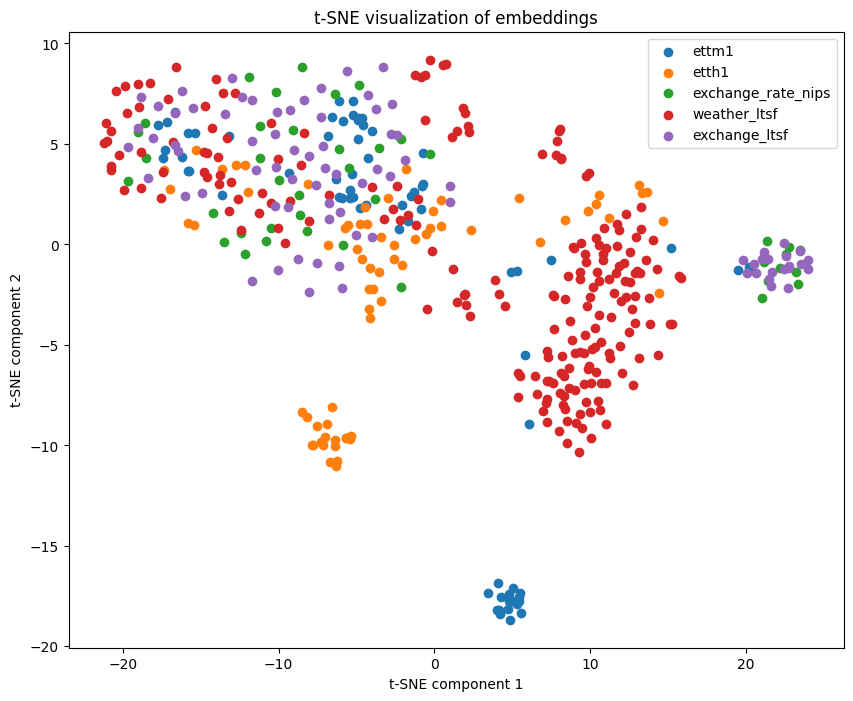

470


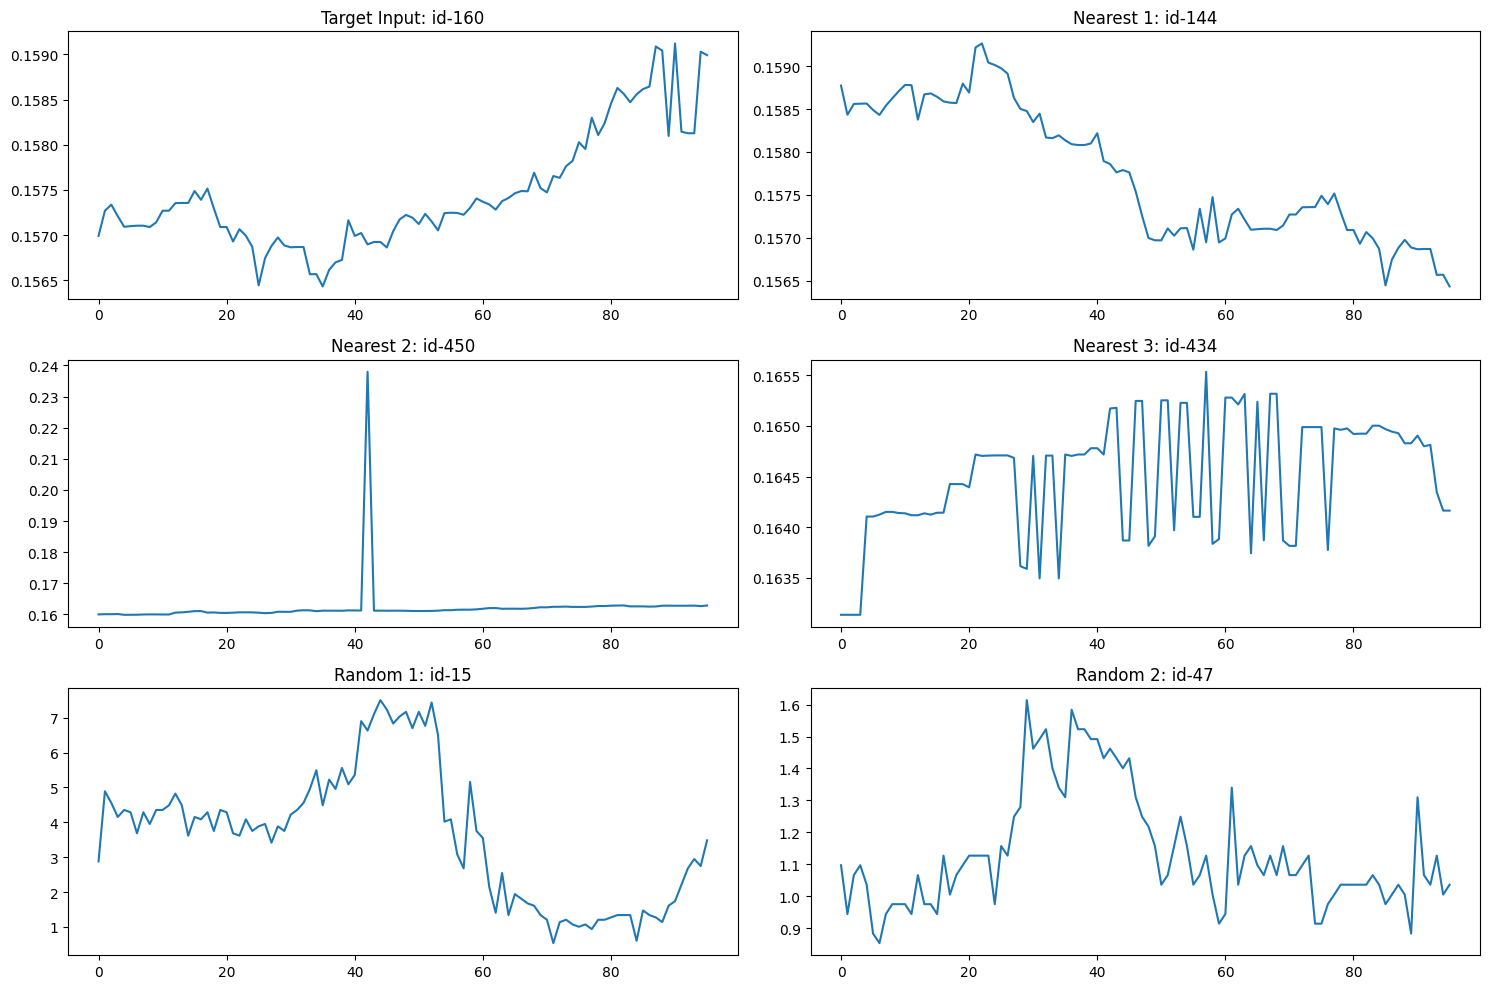

In [43]:
def get_embedding(data_loader):
    samples = []
    for i, batch in enumerate(data_loader):
        if i >= 10:  # 选择十个样本
            break
        pred, emb = patchtst.forecaster.embedding(types.SimpleNamespace(**batch))
        emb = emb.squeeze()
        # emb = torch.mean(emb, dim=1)
        samples.append((batch['past_target_cdf'].squeeze().transpose(0,1), emb))
    return samples

def plot_tsne(embeddings, dataset_names, target_id=None):
    tsne = TSNE(n_components=2, random_state=42)
    # tsne = PCA(n_components=2)
    all_embeds = np.concatenate([embed.reshape(embed.shape[0], -1) for dataset in embeddings for _, embed in dataset], axis=0)
    all_inputs = np.concatenate([batch for dataset in embeddings for batch, _ in dataset])
    print(all_embeds.shape)
    
    tsne_result = tsne.fit_transform(all_embeds)
    
    start = 0
    plt.figure(figsize=(10, 8))
    for i, (dataset_embeds, name) in enumerate(zip(embeddings, dataset_names)):
        num_points = len(dataset_embeds) * dataset_embeds[0][1].shape[0]
        plt.scatter(tsne_result[start:start + num_points, 0], tsne_result[start:start + num_points, 1], label=name)
        start += num_points
    
    plt.legend()
    plt.title('t-SNE visualization of embeddings')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()
    
    print(len(all_inputs))
    if target_id is not None:
        target_embedding = all_embeds[target_id].reshape(1, -1)
        distances = euclidean_distances(target_embedding, all_embeds).flatten()
        nearest_ids = np.argsort(distances)[1:4]  # Get the nearest 3 embeddings
        random_ids = random.sample(range(len(all_inputs)), 2)  # Randomly select 2 embeddings
        
        # Visualize the selected inputs as time-series plots
        plt.figure(figsize=(15, 10))
        
        plt.subplot(3, 2, 1)
        plt.plot(all_inputs[target_id][-96:])
        plt.title(f'Target Input: id-{target_id}')
        
        for i, nearest_id in enumerate(nearest_ids):
            plt.subplot(3, 2, i + 2)
            plt.plot(all_inputs[nearest_id][-96:])
            plt.title(f'Nearest {i+1}: id-{nearest_id}')
        
        for i, random_id in enumerate(random_ids):
            plt.subplot(3, 2, i + 5)
            plt.plot(all_inputs[random_id][-96:])
            plt.title(f'Random {i+1}: id-{random_id}')
        
        plt.tight_layout()
        plt.show()

def main(dataset_names, target_id=None):
    embeddings = []
    for name in dataset_names:
        data_manager = DataManager(name, history_length=96, context_length=96, prediction_length=96)
        data_loader = DataLoader(data_manager.test_iter_dataset, batch_size=1, shuffle=False)
        embeds = get_embedding(data_loader)
        print(name, " ", len(embeds))
        embeddings.append(embeds)
    
    plot_tsne(embeddings, dataset_names, target_id)

dataset_names = ["ettm1", "etth1", "exchange_rate_nips", "weather_ltsf", "exchange_ltsf"]
main(dataset_names, target_id=160)

# 20240713 visualize units var and emb

In [26]:
# Define function to extract embeddings
def extract_embeddings(model, test_data):
    input_it = iter(test_data)
    embeddings = []
    
    for _ in range(len(test_data)):
        input_sample = next(input_it)
        res, emb = model.embedding(torch.from_numpy(input_sample.reshape(1, -1, 1)))
        emb = emb.squeeze().flatten().detach().numpy()
        embeddings.append(emb)
    
    return np.array(embeddings)

class custom_dataloader():
    def __init__(self, data, num_samples_per_var, rolling_window=96, stride=96):
        self.data = data
        self.rolling_window = rolling_window
        self.stride = stride
        self.n_var, self.n_timesteps = data.shape
        self.num_samples_per_var = num_samples_per_var

        self.sample_indices = []
        for var in range(self.n_var):
            indices = list(range(0, self.n_timesteps - rolling_window + 1, stride))[:num_samples_per_var]
            self.sample_indices.append(indices)

    def __iter__(self):
        self.current_var = 0
        self.current_sample = 0
        return self

    def __next__(self):
        if self.current_var >= self.n_var:
            raise StopIteration

        if self.current_sample >= len(self.sample_indices[self.current_var]):
            self.current_var += 1
            self.current_sample = 0

        if self.current_var >= self.n_var:
            raise StopIteration

        start_idx = self.sample_indices[self.current_var][self.current_sample]
        batch = self.data[self.current_var, start_idx:start_idx + self.rolling_window]
        self.current_sample += 1

        return batch

    def __len__(self):
        return sum(len(indices) for indices in self.sample_indices)


In [38]:
def visualize_datasets(datasets, n_samples_per_var=1, n_vars_to_plot=10):
    all_embeddings = []
    labels = []
    label_names = []
    
    for i, dataset_name in enumerate(datasets):
        dataset = get_dataset(dataset_name)
        train_loader = iter(dataset.train)
        n_vars = int(dataset.metadata.feat_static_cat[0].cardinality)
        n_vars = min(n_vars, n_vars_to_plot)
        data = [next(train_loader)['target'] for _ in range(n_vars)]
        data = np.vstack(data)
        data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
        # print(f"{dataset_name}: ", dataset.metadata)
        data_loader = custom_dataloader(data, n_samples_per_var)
        embeddings = extract_embeddings(units, data_loader)
        print(embeddings.shape)
        all_embeddings.append(embeddings)
        for var_idx in range(n_vars):
            labels.append(np.full(n_samples_per_var, i*n_vars_to_plot + var_idx))
            label_names.append(dataset_name+f'_{var_idx}')
    
    all_embeddings = np.concatenate(all_embeddings)
    labels = np.concatenate(labels)

    print(all_embeddings.shape)
    print(labels)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_embeddings)

    # Plot results
    plt.figure(figsize=(10, 6))
    # colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', '#77B5FE']  # Extend as needed for more datasets
    for i, label in enumerate(label_names):
        indices = labels == i
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label, alpha=1)

    plt.legend()
    plt.title('t-SNE of Model Embeddings')
    # plt.xlabel('t-SNE Component 1')
    # plt.ylabel('t-SNE Component 2')
    plt.show()


    # Perform LLE
    embedding, _ = locally_linear_embedding(all_embeddings,n_neighbors=5, n_components=2)

    plt.figure(figsize=(10, 6))
    # colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', '#77B5FE']  # Extend as needed for more datasets
    for i, label in enumerate(label_names):
        indices = labels == i
        plt.scatter(embedding[indices, 0], embedding[indices, 1], label=label, alpha=1)

    plt.legend()
    plt.title('LLE of Model Embeddings')
    plt.show()

(20, 2816)
(20, 2816)
(40, 2816)
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7]


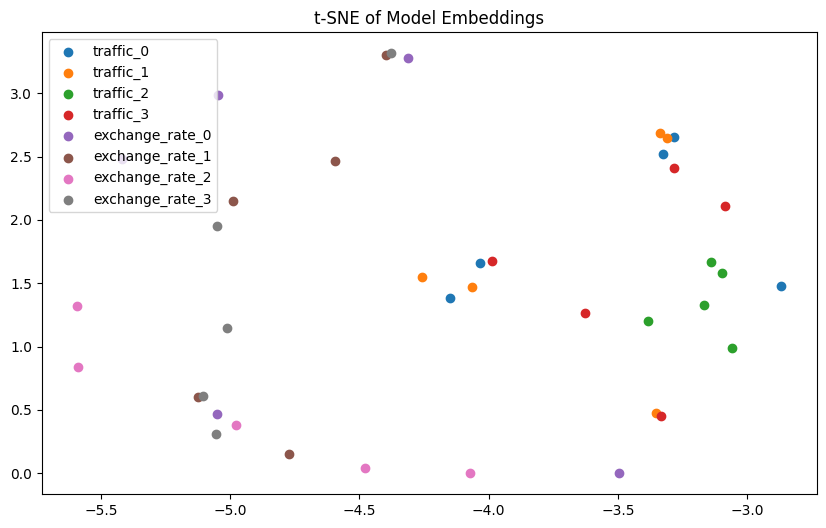

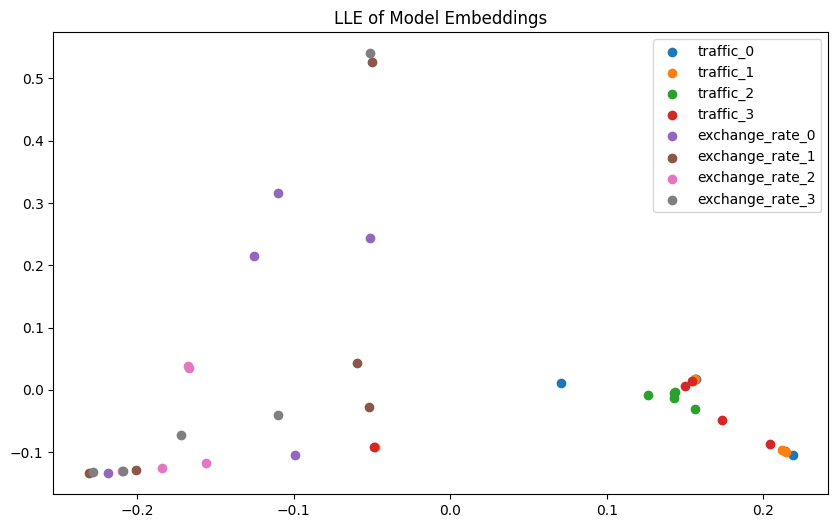

In [39]:
n_vars_to_plot = 4
n_samples_per_var = 5

datasets_to_visualize = ["traffic", "exchange_rate"]
# dataset = get_dataset(datasets_to_visualize[0])
# print(dataset.metadata)
# print("number of variables: ", dataset.metadata.feat_static_cat[0].cardinality)
# n_vars = int(dataset.metadata.feat_static_cat[0].cardinality)
# n_vars = min(n_vars, n_vars_to_plot)

# train_loader = iter(dataset.train)
# data = [next(train_loader)['target'] for _ in range(n_vars)]
# data = np.vstack(data)
# # data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)

# plt.figure(figsize=(10, 6))
# plt.plot(data[:, :96*n_samples_per_var].T)
# # Add labels to the plot
# plt.legend([f"var_{i}" for i in range(data.shape[0])])
# for i in range(1, n_samples_per_var+1):
#     plt.axvline(x=i*96, color='black', linestyle='--')
# plt.show()

visualize_datasets(datasets_to_visualize, n_samples_per_var=n_samples_per_var, n_vars_to_plot=n_vars_to_plot)

# 20240708 visualize dataset

In [116]:
# Define function to load datasets
def load_datasets(dataset_names):
    datasets = {}
    for dataset_name in dataset_names:
        test_data, metadata = get_gluonts_test_dataset(dataset_name, prediction_length=None, regenerate=False)
        print(f"{dataset_name}: ", metadata)
        datasets[dataset_name] = test_data
    return datasets

# List of datasets to visualize
datasets_to_visualize = ["electricity", "traffic", "solar_nips", "m4_hourly", "exchange_rate"]

# Load datasets
datasets = load_datasets(datasets_to_visualize)

electricity:  MetaData(freq='1H', target_dim=1, prediction_length=24, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')
traffic:  MetaData(freq='H', target_dim=1, prediction_length=24, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')
solar_nips:  MetaData(freq='H', target_dim=1, prediction_length=24, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')
m4_hourly:  MetaData(freq='H', target_dim=1, prediction_length=48, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')
exchange_rate:  MetaData(freq='1B', target_dim=1, prediction_length=30, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')


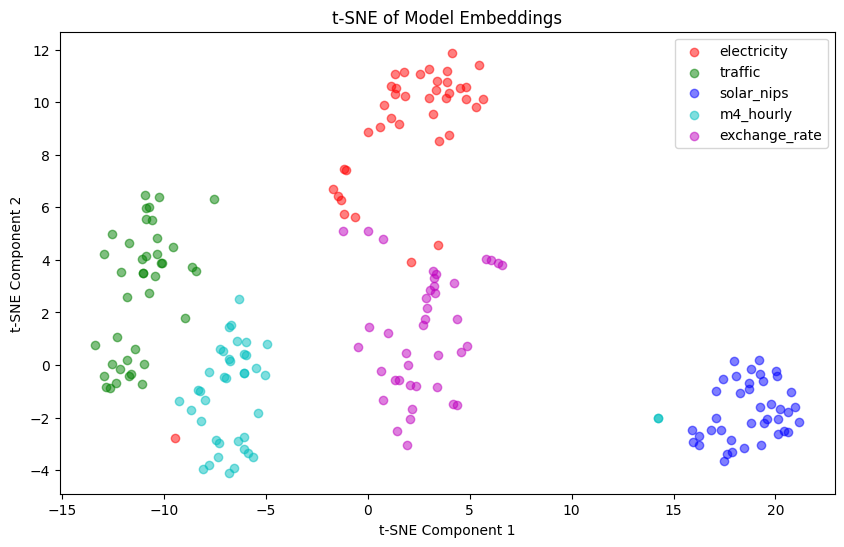

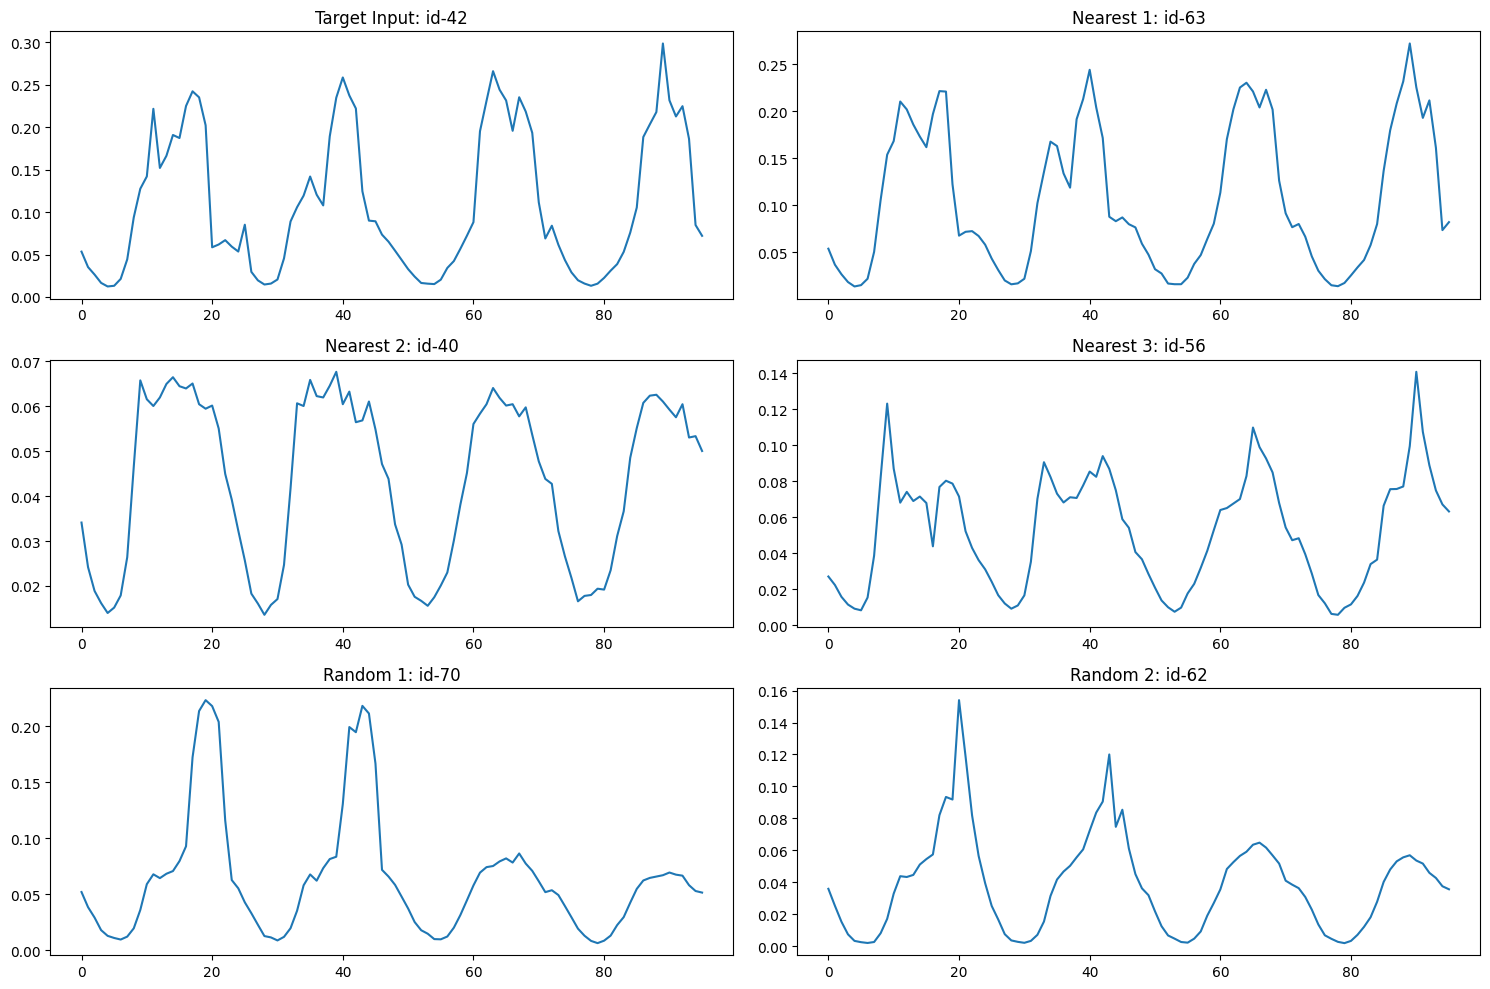

In [118]:

# Define function to extract embeddings and inputs
def extract_embeddings_and_inputs(model, test_data, num_samples=100):
    input_it = iter(test_data.input)
    embeddings = []
    inputs = []
    
    for _ in range(num_samples):
        input_sample = next(input_it)
        target = input_sample['target']  # Extract the target values
        inputs.append(target)  # Only store the target values
        res, emb = model.embedding(torch.from_numpy(target.reshape(1, -1, 1)))
        emb = emb.squeeze().flatten().detach().numpy()
        embeddings.append(emb)
    
    return np.array(embeddings), inputs

# Function to visualize datasets and perform case study
def visualize_and_case_study(datasets, num_samples=100, target_id=None):
    all_embeddings = []
    all_inputs = []
    labels = []
    label_names = []
    
    for i, (dataset_name, test_data) in enumerate(datasets.items()):
        embeddings, inputs = extract_embeddings_and_inputs(units, test_data, num_samples=num_samples)
        all_embeddings.append(embeddings)
        all_inputs.append(inputs)
        labels.append(np.full(num_samples, i))
        label_names.append(dataset_name)
    
    all_embeddings = np.concatenate(all_embeddings)
    all_inputs = sum(all_inputs, [])
    labels = np.concatenate(labels)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_embeddings)

    # Plot t-SNE results
    plt.figure(figsize=(10, 6))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Extend as needed for more datasets
    for i, label in enumerate(label_names):
        indices = labels == i
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=colors[i % len(colors)], label=label, alpha=0.5)

    plt.legend()
    plt.title('t-SNE of Model Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

    # Case study: Find nearest embeddings and visualize
    if target_id is not None:
        target_embedding = all_embeddings[target_id].reshape(1, -1)
        distances = euclidean_distances(target_embedding, all_embeddings).flatten()
        nearest_ids = np.argsort(distances)[1:4]  # Get the nearest 3 embeddings
        random_ids = random.sample(range(len(all_inputs)), 2)  # Randomly select 2 embeddings
        
        # Visualize the selected inputs as time-series plots
        plt.figure(figsize=(15, 10))
        
        plt.subplot(3, 2, 1)
        plt.plot(all_inputs[target_id][-96:])
        plt.title(f'Target Input: id-{target_id}')
        
        for i, nearest_id in enumerate(nearest_ids):
            plt.subplot(3, 2, i + 2)
            plt.plot(all_inputs[nearest_id][-96:])
            plt.title(f'Nearest {i+1}: id-{nearest_id}')
        
        for i, random_id in enumerate(random_ids):
            plt.subplot(3, 2, i + 5)
            plt.plot(all_inputs[random_id][-96:])
            plt.title(f'Random {i+1}: id-{random_id}')
        
        plt.tight_layout()
        plt.show()
# Visualize the selected datasets and perform case study
num_samples = 40
target_id = 42  # Example target ID
visualize_and_case_study(datasets, num_samples=num_samples, target_id=target_id)